In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

/kaggle/input/medical-insurance-price-prediction/Medical_insurance.csv


/tmp/ipykernel_32/223341569.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [3]:
#Extracting the medical insurance data
medical = pd.read_csv('../input/medical-insurance-price-prediction/Medical_insurance.csv')
medical.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Text(0.5, 0, 'Charges')

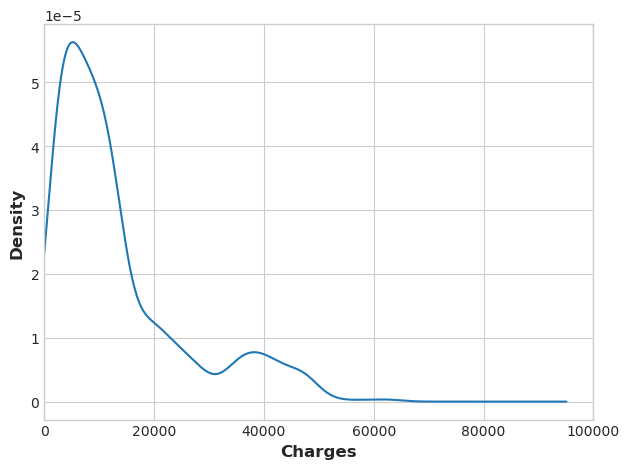

In [8]:
df = pd.DataFrame(data=medical)
ax = df['charges'].plot(kind='kde', xlabel='Charges', xlim=[0,100000])
ax.set_xlabel("Charges")

For practical purposes, rather than predicting the exact charges of a given user (regression) it may be useful to predict an insurance category/tier for a user based on their data. From the distribution of charges(in the plot above) it can be seen than a large proportion of the data points show the charges between 0-20,000, hence smaller bin sizes in that region would make sense to improve precision. So I will split the charges into 6 categories:

| Charges Range                 | Tier Name | Tier Label |
| :----------------------------:| :------:  | :----: |
| c $\le$ 5,000                | Starter   | 0 |
| 5,000 $<$ c $\le$ 10,000     | Bronze    | 1 |
| 10,000 $<$ c $\le$ 20,000    | Silver    | 2 |
| 20,000 $<$ c $\le$ 35,000    | Gold      | 3 |
| 35,000 $<$ c $\le$ 50,000    | Platinum  | 4 |
| c $>$ 50,000                 | Diamond   | 5 |

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

df['Insurance_Category'] = pd.cut(df['charges'], bins=[0, 5000, 10000, 20000, 35000, 50000, 100000],
                     labels=[0,1, 2, 3, 4,5])
df.pop('charges') #remove charges column

X = df.copy()
y = X.pop('Insurance_Category')

features_num = ['age', 'bmi', 'children']
features_cat = ['sex', 'smoker', 'region']

transformer_num = make_pipeline(
    StandardScaler(),
)
transformer_cat = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]
pd.DataFrame(X_train[:6,:]).head()

,0,1,2,3,4,5,6,7,8,9,10
0,-1.078004,-0.124584,-0.903577,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.630422,-0.293387,-0.903577,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.060947,-0.218455,-0.082897,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,-0.081422,-0.288447,-0.082897,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,-0.294975,-0.293387,1.558463,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [10]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.BatchNormalization(input_shape = input_shape),
    layers.Dense(25, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(15, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(6, activation='linear'),
])

In [11]:
model.compile(
    loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer= keras.optimizers.Adam(learning_rate=0.001),
)

In [12]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=100,
    callbacks =[early_stopping]
)

Epoch 1/100
65/65 [==============================] - 2s 6ms/step - loss: 1.7840 - val_loss: 1.5238
Epoch 2/100
65/65 [==============================] - 0s 3ms/step - loss: 1.2906 - val_loss: 1.2179
Epoch 3/100
65/65 [==============================] - 0s 3ms/step - loss: 1.0644 - val_loss: 0.9651
Epoch 4/100
65/65 [==============================] - 0s 2ms/step - loss: 0.9224 - val_loss: 0.8047
Epoch 5/100
65/65 [==============================] - 0s 3ms/step - loss: 0.8199 - val_loss: 0.7139
Epoch 6/100
65/65 [==============================] - 0s 3ms/step - loss: 0.7800 - val_loss: 0.6594
Epoch 7/100
65/65 [==============================] - 0s 3ms/step - loss: 0.7313 - val_loss: 0.6218
Epoch 8/100
65/65 [==============================] - 0s 3ms/step - loss: 0.6903 - val_loss: 0.5963
Epoch 9/100
65/65 [==============================] - 0s 3ms/step - loss: 0.7005 - val_loss: 0.5735
Epoch 10/100
65/65 [==============================] - 0s 3ms/step - loss: 0.6444 - val_loss: 0.5571
Epoch 11/

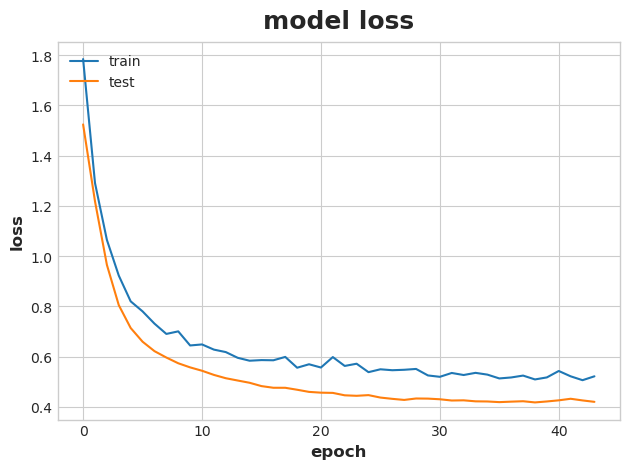

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
#add a sample user profile here, and get the prediction for which insurance category he/she would belong
newData= {
    'age':25,
    'sex' :'female',
    'bmi':31.005,
    'children':3,
    'smoker':'yes',
    'region':'northeast'
}
myData = pd.DataFrame(newData, index = [0])
transformedSample = preprocessor.transform(myData)

In [19]:
prediction = model.predict(transformedSample.reshape(1,11))  # prediction

print(f" predicting: \n{prediction}")
print(f" Largest Prediction index: {np.argmax(prediction)}")

1/1 [==============================] - 0s 17ms/step
 predicting: 
[[-3.5634515  -2.6380184   2.0261085   3.0165045   3.5978122   0.04600227]]
 Largest Prediction index: 4
